## Module 6B
## This notebook extracts and uses information from a saved CellOrganizer organelle shape model
## CellOrganizer models are Matlab structures that are saved as Matlab binary files (MAT-files, file extension .mat)
## They can be read into a python dictionary and then operated on using the appropriate keys.
### Organelle shape models (type='spharm_obj') have an unusual structure in that the proteinModel object contains a cellModel object.  This is because SPHARM-RPDM shape models originally were only supported for cells and nuclei.  The protein image is segmented into organelle objects which are fed into CellOrganizer as if they were cells.  The resulting model is stored into the proteinModel.

In [1]:
import h5py
import numpy as np
#import scipy
#import mat73
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

### There are two different versions of .mat files. Older .mat files (<v7.3) and newer .mat files (>v7.3). They require different readersin python.
### Use h5py or mat73 reader for newer .mat files and scipy.io reader for older .mat files

In [2]:
## use mat73
#load in mat file - => v7.3
# use mat73
#data_dict = mat73.loadmat('xxx.mat')
#data_dict

In [3]:
## or use h5py
f = h5py.File('/home/murphylab/cellorganizer/local/models/mito_GT_model.mat', 'r')

### examine the structure of the model

In [4]:
list(f.keys())

['#refs#', 'model']

In [5]:
model = f['model']
list(model.keys())

['dataset',
 'dimensionality',
 'documentation',
 'filename',
 'id',
 'name',
 'proteinModel']

In [6]:
proteinModel = model['proteinModel']
list(proteinModel.keys())

['class',
 'dimensionality',
 'id',
 'name',
 'resolution',
 'spharm_obj_model',
 'type']

In [7]:
#load in mat file - < v7.3
#data_dict = scipy.io('')

In [8]:
spharm_obj_model = proteinModel['spharm_obj_model']
list(spharm_obj_model.keys())

['cellShapeModel',
 'dataset',
 'dimensionality',
 'documentation',
 'filename',
 'id',
 'name',
 'spatial']

In [9]:
dataset = spharm_obj_model['dataset']
list(dataset)

['cell_membrane_images',
 'labels',
 'nuclear_membrane_images',
 'parameterization',
 'protein_images']

In [10]:
cellShapeModel = spharm_obj_model['cellShapeModel']
list(cellShapeModel.keys())

['X',
 'all_centers',
 'all_spharm_descriptors',
 'cell_params',
 'cell_params_fname',
 'class',
 'coeff',
 'components',
 'explained',
 'hausdorff_distances',
 'id',
 'latent',
 'latent_dim',
 'max_deg',
 'mu',
 'name',
 'nuc_params',
 'numimgs',
 'options',
 'parameterization_successful',
 'resolution',
 'rpdm_model_type',
 'scales',
 'score',
 'shape_model_type',
 'train_coeff',
 'train_explained',
 'train_score',
 'tsquared',
 'type',
 'version']

### first consider the object shape parameterizations

In [11]:
# this holds the full spherical harmonic descriptors for each object
cellShapeModel['X']

<HDF5 dataset "X": shape (6138, 2551), type "<f8">

In [12]:
# this holds the PCA reduced descriptors for each object (first n PCs)
cellShapeModel['train_score']

<HDF5 dataset "train_score": shape (15, 2551), type "<f8">

In [13]:
# this holds the mean coefficients
cellShapeModel['mu']

<HDF5 dataset "mu": shape (6138, 1), type "<f8">

In [14]:
# this holds the coefficients for reconstructing the full descriptors from the reduced descriptors
cellShapeModel['train_coeff']

<HDF5 dataset "train_coeff": shape (15, 6138), type "<f8">

In [15]:
# calculate the full descriptors for the first object
train_score = cellShapeModel['train_score']
train_coeff = cellShapeModel['train_coeff']
mud = cellShapeModel['mu']
print(mud.shape)
# extract the array from the dataset
mu = mud[:,0]
print(mu.shape)
# get the reducted descriptors for the first object
obj1reduced = train_score[:,0]
print(obj1reduced.shape)
# calculates the full shape descriptors from the reduced descriptors of the first object
obj1full = np.matmul(obj1reduced,train_coeff) + mu
print(obj1full.shape)

(6138, 1)
(6138,)
(15,)
(6138,)


### now consider the spatial model: position of each object in idealized spherical cell

In [16]:
spatial = spharm_obj_model['spatial']
list(spatial.keys())

['anglesphi', 'anglestheta', 'beta', 'distcodes', 'mappos_x', 'normdists']

In [17]:
anglesphi=spatial['anglesphi']
anglestheta=spatial['anglestheta']
normdists=spatial['normdists']
print(anglesphi,anglestheta,normdists)

<HDF5 dataset "anglesphi": shape (2551, 1), type "<f8"> <HDF5 dataset "anglestheta": shape (2551, 1), type "<f8"> <HDF5 dataset "normdists": shape (2551, 1), type "<f4">


### see if there is a relationships between shape and position
### (try to predict object distance from the cell center from the shape coordinates)

In [18]:
objdists = normdists[:,0]
shapedesc = np.transpose(train_score)
regress = linear_model.LinearRegression()
regress.fit(shapedesc,objdists)
print("Coefficients: \n", regress.coef_)
predict = regress.predict(shapedesc)
print("MSE=",mean_squared_error(objdists,predict))
print("R2=",r2_score(objdists,predict))

Coefficients: 
 [-0.01161167  0.04999194 -0.07945975  0.03337968  0.02088632 -0.05033602
  0.13304315  0.03420998 -0.02496661  0.0874832  -0.08094277  0.03125102
  0.08032003 -0.12681485 -0.18754547]
MSE= 0.080233442972745
R2= 0.005461189031688685


the low R2 indicates that there is no linear relationship between the two

### now look at object sizes

In [19]:
sc = cellShapeModel['scales']
print(sc)
scales = sc[0,:]

<HDF5 dataset "scales": shape (1, 2551), type "<f8">


Text(0.5, 1.0, 'Object sizes')

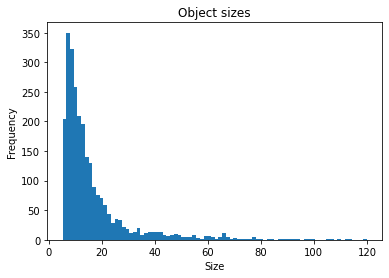

In [20]:
plt.hist(x=scales, bins='auto')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.title('Object sizes')

### see if there is a correlation between shape and size

In [21]:
print("R=",np.corrcoef(objdists,scales))

R= [[ 1.         -0.06131907]
 [-0.06131907  1.        ]]


again, weak relationship

### this is how we can get the filenames corresponding to each object

In [22]:
cell_params = cellShapeModel['cell_params']
print(cell_params)
numimgs = cellShapeModel['numimgs']
print(numimgs)
print(numimgs[0])
cell_params_fname = cellShapeModel['cell_params_fname']
print(cell_params_fname)
print(cell_params_fname[0])

<HDF5 dataset "cell_params": shape (2551, 3, 1024), type "|V16">
<HDF5 dataset "numimgs": shape (1, 1), type "<f8">
[2551.]
<HDF5 dataset "cell_params_fname": shape (2551, 1), type "|O">
[<HDF5 object reference>]


### examine quality of shape parameterizations

<HDF5 dataset "hausdorff_distances": shape (2551, 1), type "<f8">


Text(0, 0.5, 'Frequency')

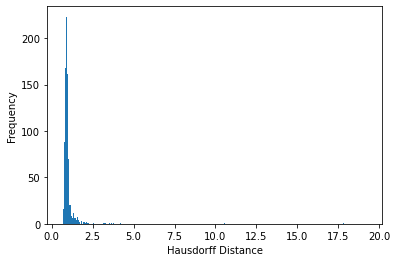

In [23]:
hd = cellShapeModel['hausdorff_distances']
print(hd)
hd = hd[:,0]
plt.hist(x=hd, bins='auto')
plt.xlabel('Hausdorff Distance')
plt.ylabel('Frequency')

In [24]:
f.close()